In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

import ed

**Exercise 7.1**

(a)

In [2]:
L = 14
g = 1.5
J = 1.
sx_list = ed.gen_sx_list(L)
sz_list = ed.gen_sz_list(L)
H = ed.gen_hamiltonian(sx_list, sz_list, g, J)
E, vecs = sp.sparse.linalg.eigsh(H, which='SA')
psi0 = vecs[:, 0]
print(E[0])
assert psi0.shape == (2**L, )
print(np.inner(psi0.conj(), H*psi0))

-23.22295943411731
-23.22295943411731


(b)

In [3]:
def compress(ψ, L: int, χ_max: int):

    ψ = ψ.reshape(1, 2**L)
    Ms = list()
    for n in range(1, L + 1, 1):

        χ, _ = ψ.shape
        # reshape next physical bond to the 'left'
        ψ = ψ.reshape(χ*2, 2**(L-n))
        # perform SVD
        M, Λ, ψ_tilde = np.linalg.svd(ψ, full_matrices=False)
        # truncate
        M = M[:, :χ_max]
        Λ = Λ[:χ_max]
        ψ_tilde = ψ_tilde[:χ_max, :]
        # reshape to MPS tensor
        M = M.reshape(χ, 2, -1)
        Ms.append(M)
        # re-absorb singular value matrix 
        ψ =  Λ[:, None] * ψ_tilde

    # check norm
    norm = ψ.item()
    assert np.isclose(norm, 1.)

    return Ms


(c)  
The number of non-zero singular values at bond $n+1$ is equal to the rank of the matrix $\psi_{L_{n}, R_{n}}$ to be decomposed by SVD.  
Since $\mathrm{rk(\psi_{L_{n}, R_{n}})}\le\min\{2^n, \,2^{L-n}\}\le 2^{\lfloor{L/2}\rfloor}$, any tensor with physical bond dimensions of 2 each can be represented exactly by an MPS with $\chi_{\mathrm{max}}=2^{\lfloor{L/2}\rfloor}$.  
However, this is only needed for the intermediate bond. In fact, the maximally necessary bond dimension decreases exponentially when proceeding to the outer bonds (cf. first bound).

In [4]:
mps_ex = compress(psi0, L, 2**7)

(d)

In [5]:
mps_compr = compress(psi0, L, 10)

In [6]:
sum([M.size for M in mps_ex]), sum([M.size for M in mps_compr])

(43688, 1688)

(e)

In [7]:
def inner_product(mps_a: list, mps_b: list):

    L = len(mps_a)
    assert L == len(mps_b)

    t = np.tensordot(mps_b[0], mps_a[0].conj(), axes=[1, 1]) # vL [j] vR, vL* [j*] vR*
    t = t.squeeze(axis=(0, 2))  # vR vR*

    for n in range(1, L):

        t = np.tensordot(t, mps_b[n], axes=[0, 0]) # [vR] vR*, [vL] j vR
        t = np.tensordot(t, mps_a[n].conj(), axes=[[0, 1], [0, 1]]) # [vR*] [j] vR, [vL*] [j*] vR*

    return t.item()

In [8]:
np.isclose(1, inner_product(mps_ex, mps_ex))

True

In [9]:
inner_product(mps_ex, mps_compr)

0.9999999999999898

(f)

In [10]:
mps_spinup = [np.array([1., 0.]).reshape(1, 2, 1) for _ in range(L)]

In [11]:
inner_product(mps_spinup, mps_compr)

0.8146943346076264

**Exercise 7.2**

(a)

In [12]:
def construct_mps_singlets(L):
    """construct 2L-2 pairs of singlets and single spin-ups on the edges"""

    spin_up = np.array([1, 0]).reshape(1, 2, 1)

    M_odd_up, M_odd_down = [[1/np.sqrt(2), 0]], [[0, -1/np.sqrt(2)]]    
    M_odd = np.swapaxes([M_odd_up, M_odd_down], 0, 1)

    M_even_up, M_even_down = [[0], [1]], [[1], [0]]
    M_even = np.swapaxes([M_even_up, M_even_down], 0, 1)

    mps = [spin_up] + [M_odd if n % 2 == 1 else M_even for n in range(1, 2*L - 1)] + [spin_up]

    return mps

In [13]:
mps_singlets = construct_mps_singlets(L)

(b)

In [14]:
inner_product(mps_singlets, mps_singlets)

0.9999999999999979

In [15]:
def correlation(mps, op):
    
    L = len(mps)
    C = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            
            mps_copy = mps.copy()

            t = np.tensordot(mps_copy[i], op, axes=[1, 1]) # vL [i] vR, i [k]
            mps_copy[i] = np.transpose(t, axes=[0, 2, 1]) # vL i vR

            t = np.tensordot(mps_copy[j], op, axes=[1, 1]) # vL [j] vR, j [k]
            mps_copy[j] = np.transpose(t, axes=[0, 2, 1]) # vL j vR

            C[i, j] = inner_product(mps, mps_copy)

            del mps_copy

    return C

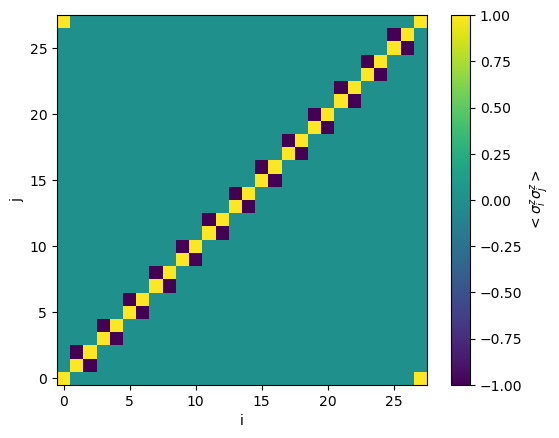

In [16]:
sz = np.diag([1, -1])
C_singlets = correlation(mps_singlets, sz)

fig, ax = plt.subplots(1, 1)
img = ax.imshow(C_singlets, origin='lower')
plt.colorbar(img, ax=ax, label='$<\sigma^{z}_{i} \sigma^{z}_{j}>$')
ax.set_xlabel('i'), ax.set_ylabel('j');

Note that the correlation function for the single spins on the edges is ${\bra{\uparrow} \sigma \ket{\uparrow}}^{2}=1$.  
For all other $|i-j|>1$, the correlation function vanishes and the singlets show anti-correlated measurement results as expected.

(c) + (d)

In [17]:
def construct_P():
    P_plus = [[1, 0], [0, 0]]
    P_minus = [[0, 0], [0, 1]]
    P_zero = np.array([[0, 1], [1, 0]]) / np.sqrt(2)
    P = np.array([P_plus, P_zero, P_minus])
    return P

In [18]:
def construct_aklt(L):

    mps_singlets = construct_mps_singlets(L)
    P = construct_P()
    
    aklt = []
    for (M_even, M_odd) in zip(mps_singlets[::2], mps_singlets[1::2]):
        
        t = np.tensordot(M_even, P, axes=[1, 1]) # eL [j] eR, j [pL] pR
        t = np.tensordot(t, M_odd, axes=[3, 1]) # eL eR j [pR], oL [j] oR
        M = t.squeeze(axis=(1, 3)) # eL eR j oL oR -> eL j oR
        aklt.append(M)

    # P is non-unitary, normalization is necessary
    norm = inner_product(aklt, aklt)**(0.5)
    aklt = [M / norm**(1/L) for M in aklt]

    return aklt

In [19]:
mps_aklt = construct_aklt(L)

np.isclose(1, inner_product(mps_aklt, mps_aklt))

True

(e)

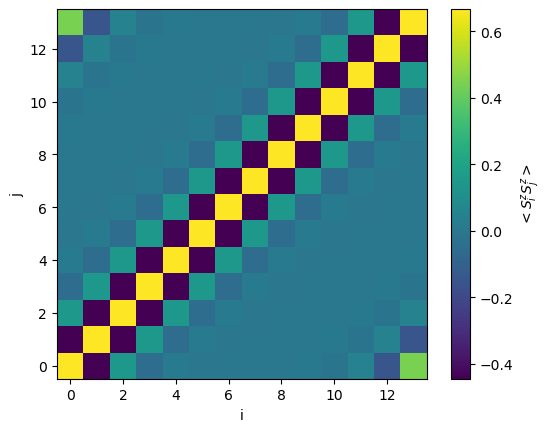

In [20]:
Sz = np.diag([1, 0, -1])
C_aklt = correlation(mps_aklt, Sz)

fig, ax = plt.subplots(1, 1)
img = ax.imshow(C_aklt, origin='lower')
plt.colorbar(img, ax=ax, label='$<S^{z}_{i} S^{z}_{j}>$')
ax.set_xlabel('i'), ax.set_ylabel('j');